# Creating Redshift Cluster using the AWS python SDK

In [ ]:
# Import packages
import pandas as pd
import boto3
import json
from botocore.exceptions import ClientError
from sqlalchemy import create_engine
import psycopg2

## Create a New IAM User

1. **Create an IAM User**
   - Log in to your AWS account and create a new IAM user.

2. **Assign Administrator Access**
   - Under the **Attach existing policies directly** tab, assign the `AdministratorAccess` policy to the user.

3. **Save Access Credentials**
   - Note down the **Access Key** and **Secret Key** provided after creating the user. You will need these for configuration.

4. **Update the Configuration File**
   - Open the `dwh.cfg` file located in the same folder as this notebook, and fill in the details.

Make sure your configuration file contains the following block with your actual AWS Access Key and Secret Key:

```ini
[AWS]
KEY=YOUR_AWS_ACCESS_KEY
SECRET=YOUR_AWS_SECRET_KEY


## Load DWH Params from a file

In [14]:
import configparser
config = configparser.ConfigParser()
config.read_file(open('dwh.cfg'))

KEY                    = config.get('AWS','KEY')
SECRET                 = config.get('AWS','SECRET')

DWH_CLUSTER_TYPE       = config.get("DWH","DWH_CLUSTER_TYPE")
DWH_NUM_NODES          = config.get("DWH","DWH_NUM_NODES")
DWH_NODE_TYPE          = config.get("DWH","DWH_NODE_TYPE")

DWH_CLUSTER_IDENTIFIER = config.get("DWH","DWH_CLUSTER_IDENTIFIER")
DWH_DB                 = config.get("DWH","DWH_DB")
DWH_DB_USER            = config.get("DWH","DWH_DB_USER")
DWH_DB_PASSWORD        = config.get("DWH","DWH_DB_PASSWORD")
DWH_PORT               = config.get("DWH","DWH_PORT")

DWH_IAM_ROLE_NAME      = config.get("DWH", "DWH_IAM_ROLE_NAME")

(DWH_DB_USER, DWH_DB_PASSWORD, DWH_DB)

pd.DataFrame({"Param":
                  ["DWH_CLUSTER_TYPE", "DWH_NUM_NODES", "DWH_NODE_TYPE", "DWH_CLUSTER_IDENTIFIER", "DWH_DB", "DWH_DB_USER", "DWH_DB_PASSWORD", "DWH_PORT", "DWH_IAM_ROLE_NAME"],
              "Value":
                  [DWH_CLUSTER_TYPE, DWH_NUM_NODES, DWH_NODE_TYPE, DWH_CLUSTER_IDENTIFIER, DWH_DB, DWH_DB_USER, DWH_DB_PASSWORD, DWH_PORT, DWH_IAM_ROLE_NAME]
             })

,Param,Value
0,DWH_CLUSTER_TYPE,multi-node
1,DWH_NUM_NODES,4
2,DWH_NODE_TYPE,dc2.large
3,DWH_CLUSTER_IDENTIFIER,dwhCluster
4,DWH_DB,dwh
5,DWH_DB_USER,dwhuser
6,DWH_DB_PASSWORD,Passw0rd
7,DWH_PORT,5439
8,DWH_IAM_ROLE_NAME,DWH_IAM_ROLE_NAME


# Create clients for IAM, EC2, S3 and Redshift
**Note**: We are creating these resources in the the **us-west-2** region. Choose the same region in the your AWS web console to the see these resources.

In [15]:
import boto3

ec2 = boto3.resource('ec2',
                       region_name="us-west-2",
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET
                    )

s3 = boto3.resource('s3',
                       region_name="us-west-2",
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET
                   )

iam = boto3.client('iam',aws_access_key_id=KEY,
                     aws_secret_access_key=SECRET,
                     region_name='us-west-2'
                  )

redshift = boto3.client('redshift',
                       region_name="us-west-2",
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET
                       )

# Create an IAM ROLE
- Create an IAM Role that makes Redshift able to access S3 bucket (ReadOnly)

In [ ]:
from botocore.exceptions import ClientError

#1.1 Create the role, 
try:
    print("1.1 Creating a new IAM Role") 
    dwhRole = iam.create_role(
        Path='/',
        RoleName=DWH_IAM_ROLE_NAME,
        Description = "Allows Redshift clusters to call AWS services on your behalf.",
        AssumeRolePolicyDocument=json.dumps(
            {'Statement': [{'Action': 'sts:AssumeRole',
               'Effect': 'Allow',
               'Principal': {'Service': 'redshift.amazonaws.com'}}],
             'Version': '2012-10-17'})
    )    
except Exception as e:
    print(e)
    
    
print("1.2 Attaching Policy")

iam.attach_role_policy(RoleName=DWH_IAM_ROLE_NAME,
                       PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
                      )['ResponseMetadata']['HTTPStatusCode']

print("1.3 Get the IAM role ARN")
roleArn = iam.get_role(RoleName=DWH_IAM_ROLE_NAME)['Role']['Arn']

print(roleArn)

# Create Redshift Cluster

- Create a [RedShift Cluster](https://console.aws.amazon.com/redshiftv2/home)
- For complete arguments to `create_cluster`, see [docs](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/redshift.html#Redshift.Client.create_cluster)

In [18]:
try:
    response = redshift.create_cluster(        
        #HW
        ClusterType=DWH_CLUSTER_TYPE,
        NodeType=DWH_NODE_TYPE,
        NumberOfNodes=int(DWH_NUM_NODES),

        #Identifiers & Credentials
        DBName=DWH_DB,
        ClusterIdentifier=DWH_CLUSTER_IDENTIFIER,
        MasterUsername=DWH_DB_USER,
        MasterUserPassword=DWH_DB_PASSWORD,
        
        #Roles (for s3 access)
        IamRoles=[roleArn]  
    )
except Exception as e:
    print(e)

##  Describe the cluster to see its status
- run this block several times until the cluster status becomes `Available`

In [ ]:
def prettyRedshiftProps(props):
    pd.set_option('display.max_colwidth', 1)
    keysToShow = ["ClusterIdentifier", "NodeType", "ClusterStatus", "MasterUsername", "DBName", "Endpoint", "NumberOfNodes", 'VpcId']
    x = [(k, v) for k,v in props.items() if k in keysToShow]
    return pd.DataFrame(data=x, columns=["Key", "Value"])

myClusterProps = redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]
prettyRedshiftProps(myClusterProps)

<h2> Take note of the cluster <font color='red'> endpoint and role ARN </font> </h2>

<font color='red'>DO NOT RUN THIS unless the cluster status becomes "Available". Make ure you are checking your Amazon Redshift cluster in the **us-west-2** region. </font>


In [ ]:
DWH_ENDPOINT = myClusterProps['Endpoint']['Address']
DWH_ROLE_ARN = myClusterProps['IamRoles'][0]['IamRoleArn']
print("DWH_ENDPOINT :: ", DWH_ENDPOINT)
print("DWH_ROLE_ARN :: ", DWH_ROLE_ARN)

## Open an incoming  TCP port to access the cluster ednpoint

In [23]:
try:
    vpc = ec2.Vpc(id=myClusterProps['VpcId'])
    defaultSg = list(vpc.security_groups.all())[0]
    print(defaultSg)
    defaultSg.authorize_ingress(
        GroupName=defaultSg.group_name,
        CidrIp='0.0.0.0/0',
        IpProtocol='TCP',
        FromPort=int(DWH_PORT),
        ToPort=int(DWH_PORT)
    )
except Exception as e:
    print(e)

ec2.SecurityGroup(id='sg-0d575390187d977d3')
An error occurred (InvalidPermission.Duplicate) when calling the AuthorizeSecurityGroupIngress operation: the specified rule "peer: 0.0.0.0/0, TCP, from port: 5439, to port: 5439, ALLOW" already exists


## Make sure you can connect to the cluster

In [15]:
import redshift_connector

conn = redshift_connector.connect(host=DWH_ENDPOINT,database=DWH_DB,user=DWH_DB_USER,password=DWH_DB_PASSWORD, port=int(DWH_PORT) ) # Ensure the port is an integer)
print("Connected to Redshift!")
cur = conn.cursor()


Connected to Redshift!


In [ ]:
conn_string = "redshift+psycopg2://{}:{}@{}:{}/{}".format(DWH_DB_USER, DWH_DB_PASSWORD, DWH_ENDPOINT, DWH_PORT, DWH_DB)
print(conn_string)

# Run python code to create tables

In [ ]:
%run -i "create_tables.py"

# Run python code to copy and insert data

In [25]:
%run -i "etl.py"

# Varify counts to make sure data was imported

In [27]:
import redshift_connector
import pandas as pd
import matplotlib.pyplot as plt


# Connect
import redshift_connector

conn = redshift_connector.connect(host=DWH_ENDPOINT,database=DWH_DB,user=DWH_DB_USER,password=DWH_DB_PASSWORD, port=int(DWH_PORT) ) # Ensure the port is an integer)
print("Connected to Redshift!")
cur = conn.cursor()

cur.execute("""
SELECT * FROM (
SELECT 'staging_events' AS table_name, COUNT(*) AS total_records FROM staging_events
UNION ALL
SELECT 'staging_songs' AS table_name, COUNT(*) AS total_records FROM staging_events
UNION ALL
SELECT 'songplays' AS table_name, COUNT(*) AS total_records FROM songplays
UNION ALL
SELECT 'users' AS table_name, COUNT(*) AS total_records FROM users
UNION ALL
SELECT 'songs' AS table_name, COUNT(*) AS total_records FROM songs
UNION ALL
SELECT 'artists' AS table_name, COUNT(*) AS total_records FROM artists
UNION ALL
SELECT 'time' AS table_name, COUNT(*) AS total_records FROM time
) AS A;
""")
results = cur.fetchall()

# Define column names based on the query
columns = ["table_name", "total_records"]

# Convert to pandas DataFrame
df = pd.DataFrame(results, columns=columns)
print(df)

# Close when done
cur.close()


Connected to Redshift!
       table_name  total_records
0  users           104          
1  artists         10025        
2  staging_events  8056         
3  staging_songs   8056         
4  songplays       333          
5  songs           14896        
6  time            333          


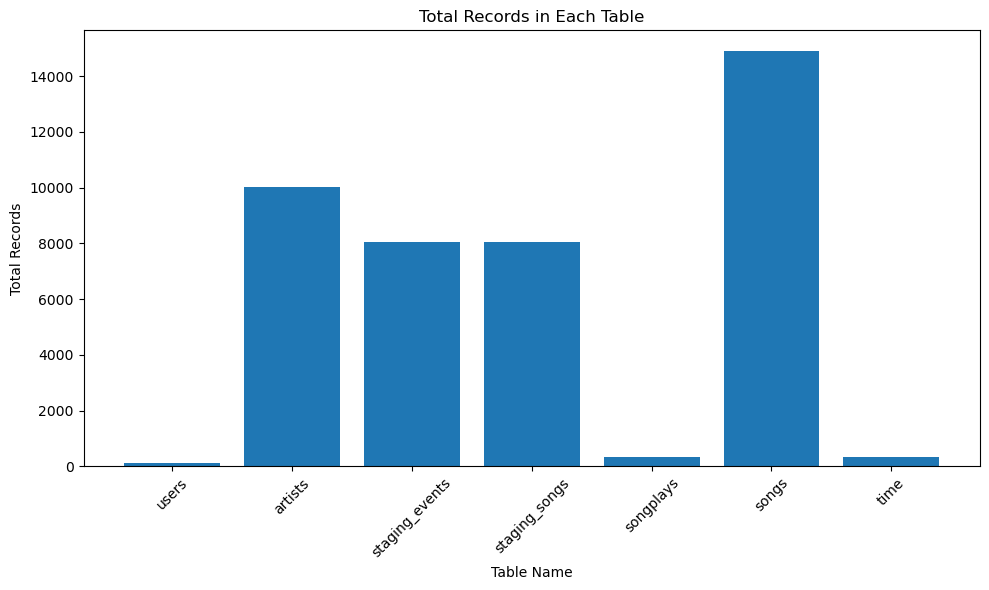

In [28]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(df['table_name'], df['total_records'])
plt.title('Total Records in Each Table')
plt.xlabel('Table Name')
plt.ylabel('Total Records')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()       # Adjust layout to prevent clipping
plt.show()


# STEP 5: Clean up your resources

<b><font color='red'>DO NOT RUN THIS UNLESS YOU ARE SURE <br/> 
    We will be using these resources in the next exercises</span></b>

In [ ]:
#### CAREFUL!!
#-- Uncomment & run to delete the created resources
redshift.delete_cluster( ClusterIdentifier=DWH_CLUSTER_IDENTIFIER,  SkipFinalClusterSnapshot=True)
#### CAREFUL!!

- run this block several times until the cluster really deleted

In [ ]:
myClusterProps = redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]
prettyRedshiftProps(myClusterProps)

In [ ]:
#### CAREFUL!!
#-- Uncomment & run to delete the created resources
iam.detach_role_policy(RoleName=DWH_IAM_ROLE_NAME, PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess")
iam.delete_role(RoleName=DWH_IAM_ROLE_NAME)
#### CAREFUL!!